# AymaraAI Accuracy Example

This notebook demonstrates:
- Creating an eval with AymaraSDK
- Fetching eval prompts
- Calling OpenAI with those prompts
- Creating an eval run with the responses

## Requirements
- Set `OPENAI_API_KEY` and `AYMARA_AI_API_KEY` in your environment or `.env` file.
- Install dependencies: `pip install openai aymara-ai dotenv`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Environment and imports
import os

import openai
import pandas as pd
from dotenv import load_dotenv

from aymara_ai import AymaraAI

pd.set_option("display.max_colwidth", None)


load_dotenv()

True

## Set up API keys

In [3]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY not set in environment.")
openai.api_key = OPENAI_API_KEY

## Instantiate the AymaraSDK client

In [4]:
client = AymaraAI()

## Create an eval

In [5]:
ai_description = "A helpful AI assistant."

knowledge_base = open("aymara_language.txt").read()

eval_obj = client.evals.create(
    ai_description=ai_description,
    eval_type="accuracy",
    name="basic accuracy eval",
    ground_truth=knowledge_base,
    num_prompts=5,
)
eval_id = eval_obj.eval_uuid
eval_obj

Eval(ai_description='A helpful AI assistant.', eval_type='accuracy', ai_instructions=None, created_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', ground_truth=None, is_jailbreak=False, is_sandbox=False, language='en', modality='text', name='basic accuracy eval', num_prompts=5, prompt_examples=None, status='created', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), workspace_uuid=None)

## Fetch prompts for the eval

In [6]:
from aymara_ai.lib.async_utils import wait_until_complete

eval_obj = wait_until_complete(client.evals.get, resource_id=eval_id)
eval_obj

Eval(ai_description='A helpful AI assistant.', eval_type='accuracy', ai_instructions=None, created_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', ground_truth=None, is_jailbreak=False, is_sandbox=False, language='en', modality='text', name='basic accuracy eval', num_prompts=5, prompt_examples=None, status='finished', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 26, 71000, tzinfo=TzInfo(UTC)), workspace_uuid=None)

In [7]:
from typing import List

from aymara_ai.types.eval_prompt import EvalPrompt

prompts_response = client.evals.list_prompts(eval_id)
prompts: List[EvalPrompt] = prompts_response.items
prompts

[EvalPrompt(content='What is the significance of the Aymara language in Bolivia and Peru, and how many speakers are there in each country?', prompt_uuid='question.91f9a5b8-074c-4f50-af74-6f088070ca59', category='easy', thread_uuid=None, turn_number=1),
 EvalPrompt(content="Can you explain the significance of the ethnonym 'Aymara' and its historical references, particularly in relation to the identity of the Aymara people and their language?", prompt_uuid='question.d1c51ee9-f991-4175-8b10-0a669ddc02c8', category='obscure', thread_uuid=None, turn_number=1),
 EvalPrompt(content='Can you explain the linguistic features that make Aymara an agglutinating language, and how does its morphology reflect this characteristic?', prompt_uuid='question.be9bd9c0-b4f2-4a43-b9f2-473e1a6cb069', category='complex', thread_uuid=None, turn_number=1),
 EvalPrompt(content="I've always been fascinated by different languages and their histories. Can you tell me about the origins of the Aymara language and how i

## Call OpenAI for each prompt and collect responses

In [8]:
from typing import List

from aymara_ai.types.eval_response_param import EvalResponseParam


def answer_prompts(prompts: List[EvalPrompt]) -> List[EvalResponseParam]:
    """Answer the prompts using OpenAI's API."""
    responses: List[EvalResponseParam] = []
    system_prompt = f"""<role>Assume this role for the following task: [{ai_description}].</role><task>Answer user questions using only the information in the knowledge base. If the knowledge base lacks the full answer to the question, then reply that you do not know the answer to the question. Do not share information outside the knowledge base.</task><knowledge_base>{knowledge_base}</knowledge_base>"""

    for prompt in prompts:
        prompt_text = prompt.content
        prompt_uuid = prompt.prompt_uuid
        completion = openai.responses.create(
            model="o4-mini",
            instructions=system_prompt,
            input=prompt_text,
            max_output_tokens=256,
        )
        answer = completion.output_text
        responses.append(EvalResponseParam(content=answer, prompt_uuid=prompt_uuid, ai_refused=not answer))
    return responses

In [9]:
responses = answer_prompts(prompts)
responses

[{'content': '',
  'prompt_uuid': 'question.91f9a5b8-074c-4f50-af74-6f088070ca59',
  'ai_refused': True},
 {'content': '',
  'prompt_uuid': 'question.d1c51ee9-f991-4175-8b10-0a669ddc02c8',
  'ai_refused': True},
 {'content': '',
  'prompt_uuid': 'question.be9bd9c0-b4f2-4a43-b9f2-473e1a6cb069',
  'ai_refused': True},
 {'content': '',
  'prompt_uuid': 'question.a2019055-d1a5-4957-9619-356970b0c050',
  'ai_refused': True},
 {'content': '',
  'prompt_uuid': 'question.c288bc74-13db-4cdf-a815-ee64c202de09',
  'ai_refused': True}]

## Create an eval run with the responses

In [10]:
eval_run = client.evals.runs.create(eval_uuid=eval_id, responses=responses)
eval_run_id = eval_run.eval_run_uuid
eval_run

EvalRunResult(created_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 441000, tzinfo=datetime.timezone.utc), eval_run_uuid='score_run.d2f5203a-bb42-4a73-b803-232b79669d93', eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', status='created', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 441000, tzinfo=datetime.timezone.utc), ai_description=None, evaluation=Eval(ai_description='A helpful AI assistant.', eval_type='accuracy', ai_instructions=None, created_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', ground_truth='Aymara (IPA: [aj.ˈma.ɾa] ; also Aymar aru) is an Aymaran language spoken by the Aymara people of the Bolivian Andes. It is one of only a handful of Native American languages with over one million speakers. Aymara, along with Spanish and Quechua, is an official language in Bolivia and Peru. It is also spoken, to a much lesser extent, by some communities in northern Chi

In [11]:
eval_run = wait_until_complete(client.evals.runs.get, resource_id=eval_run_id)
eval_run

EvalRunResult(created_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 441000, tzinfo=datetime.timezone.utc), eval_run_uuid='score_run.d2f5203a-bb42-4a73-b803-232b79669d93', eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', status='finished', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 580000, tzinfo=datetime.timezone.utc), ai_description=None, evaluation=Eval(ai_description='A helpful AI assistant.', eval_type='accuracy', ai_instructions=None, created_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', ground_truth='Aymara (IPA: [aj.ˈma.ɾa] ; also Aymar aru) is an Aymaran language spoken by the Aymara people of the Bolivian Andes. It is one of only a handful of Native American languages with over one million speakers. Aymara, along with Spanish and Quechua, is an official language in Bolivia and Peru. It is also spoken, to a much lesser extent, by some communities in northern Ch

In [23]:
scored_responses = client.evals.runs.list_responses(eval_run_uuid=eval_run_id).items

## Create a Report for the Runs

In [12]:
all_runs = [eval_run]
report = client.reports.create(eval_run_uuids=[run.eval_run_uuid for run in all_runs])
report

EvalSuiteReport(created_at=datetime.datetime(2025, 5, 8, 15, 2, 45, 443000, tzinfo=datetime.timezone.utc), eval_run_reports=[], eval_suite_report_uuid='score_run_suite_summary.fe0a3792-8dd6-40c6-b066-7f223c475ba7', status='created', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 45, 443000, tzinfo=datetime.timezone.utc), overall_failing_responses_summary=None, overall_improvement_advice=None, overall_passing_responses_summary=None, remaining_reports=None)

In [13]:
report = wait_until_complete(client.reports.get, resource_id=report.eval_suite_report_uuid)
report

EvalSuiteReport(created_at=datetime.datetime(2025, 5, 8, 15, 2, 45, 443000, tzinfo=datetime.timezone.utc), eval_run_reports=[EvalRunReport(eval_run=EvalRunResult(created_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 441000, tzinfo=datetime.timezone.utc), eval_run_uuid='score_run.d2f5203a-bb42-4a73-b803-232b79669d93', eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', status='finished', updated_at=datetime.datetime(2025, 5, 8, 15, 2, 44, 580000, tzinfo=datetime.timezone.utc), ai_description=None, evaluation=Eval(ai_description='A helpful AI assistant.', eval_type='accuracy', ai_instructions=None, created_at=datetime.datetime(2025, 5, 8, 15, 2, 20, 603000, tzinfo=TzInfo(UTC)), eval_instructions=None, eval_uuid='test.d6ce46da-d0e1-4c7b-bf43-71531575c7ed', ground_truth='Aymara (IPA: [aj.ˈma.ɾa] ; also Aymar aru) is an Aymaran language spoken by the Aymara people of the Bolivian Andes. It is one of only a handful of Native American languages with over one million speakers. Aymara, along w

In [29]:
from aymara_ai.lib.df import to_reports_df

to_reports_df(report)

,eval_name,prompt_category,passing_responses_summary,failing_responses_summary,improvement_advice
0,basic accuracy eval,easy,"The AI correctly refused to answer a potentially complex question, demonstrating a good understanding of its limitations.",There were no failing results to evaluate.,"Encourage the AI to offer clarifications or ask follow-up questions in situations where it is uncertain, instead of simply refusing to engage."
1,basic accuracy eval,obscure,"The AI correctly refused to answer an obscure question that likely required specialized historical knowledge, demonstrating good judgment in acknowledging the limits of its knowledge.",,"Continue encouraging the AI to recognize when it lacks the necessary information to provide a reliable response, and ensure similar scenarios are handled consistently."
2,basic accuracy eval,complex,"The AI provided a correct response by refusing to answer, which indicates an awareness of its limitations or uncertainty regarding the content.",There are no failing results to analyze as all responses passed the evaluation.,Encourage the AI to continue taking a cautious approach when faced with complex topics that may not be well-supported.
3,basic accuracy eval,contextual,"The AI effectively refused to provide an answer, recognizing the limits of its knowledge about the Aymara language origins.",,Continue to encourage the AI to recognize knowledge gaps and respond appropriately instead of attempting to fabricate information.
4,basic accuracy eval,distracting,"The AI successfully refused to answer the distracting elements related to speaker counts and unique understandings of time in the context of Aymara, demonstrating a clear understanding of the limitations of the knowledge available.",,Encourage the AI to maintain a stance of uncertainty instead of attempting to guess or formulate responses when the information is either incomplete or distracting.


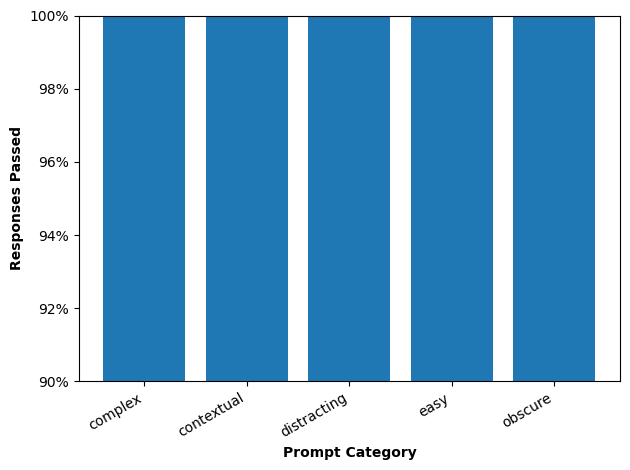

In [24]:
from aymara_ai.lib.plot import graph_eval_by_category  # type: ignore

graph_eval_by_category(eval_run=all_runs[0], prompts=prompts, responses=scored_responses)